# C. Modèle de type Hodgkin-Huxley

Aujourd'hui, nous allons voir comment créer un modèle de neurone de type Hodgkin-Huxley [1] (Prix Nobel en 1963). Plus précisément, nous allons simuler les dynamiques d'un potentiel d'action généré par ce modèle. <p>

[1] Hodgkin, A.L. and Huxley, A.F. (1952). A quantitative description of membrane current and its application to conduction and excitation in nerve *J. Physiol.*, doi : 10.1113/jphysiol.1952.sp004764 <br>

In [4]:
import matplotlib.pyplot as plt
import numpy as np

Le potentiel membranaire du neurone Hodgkin-Huxley est donné par :

$$C_\mathrm{m}\dot{V}=I_\mathrm{s} - I_{fuite} - I_{K} - I_{Na}$$
$$\dot{n} = \alpha_\mathrm{n}(1-n)-\beta_\mathrm{n}n$$
$$\dot{m} = \alpha_\mathrm{m}(1-m)-\beta_\mathrm{m}m$$
$$\dot{h} = \alpha_\mathrm{h}(1-h)-\beta_\mathrm{h}h$$

avec

$$\begin{array}{l l l l l l l}
\begin{array}{l}
I_\mathrm{Na} = g_\mathrm{Na} m^{3}h(V - E_\mathrm{Na}) \\
I_\mathrm{K} = g_\mathrm{K}n^{4} (V - E_\mathrm{K}) \\
I_\mathrm{fuite} = g_\mathrm{fuite}(V - E_\mathrm{fuite}) 
\end{array} & \ \ \ \ \ \ & 
\begin{array}{l}
\alpha_\mathrm{n} = \frac{0.01(10-(V + 65))}{e^{\left(\frac{10-(V + 65)}{10}\right)}-1} \\
\alpha_\mathrm{m} = \frac{0.1(25-(V + 65))}{e^{\left(\frac{25-(V + 65)}{10}\right)}-1} \\
\alpha_\mathrm{h} = 0.07e^{\frac{-(V + 65)}{20}}
\end{array} & \ \ \ \ \ \ &
\begin{array}{l}
\beta_\mathrm{n} = 0.125e^{-0.0125(V + 65)} \\
\beta_\mathrm{m} = 4e^{-0.0556(V + 65)} \\
\beta_\mathrm{h} = \frac{1}{1+e^{\left(3-0.1(V + 65.0)\right)}} 
\end{array} & \ \ \ \ \ \ &
\begin{array}{l}
\tau_\mathrm{n} = \frac{1}{\alpha_\mathrm{n} + \beta_\mathrm{n}} \\
\tau_\mathrm{m} = \frac{1}{\alpha_\mathrm{m} + \beta_\mathrm{m}} \\
\tau_\mathrm{h} = \frac{1}{\alpha_\mathrm{h} + \beta_\mathrm{h}} 
\end{array}
\end{array} 
$$
     
**Question 1 :** <br>
Compléter le code ci-dessous en ajoutant :
- Les paramètres du modèles tels que :

$g_\mathrm{fuite} = 0.3~\mathrm{mS}$, $g_\mathrm{K} = 36~\mathrm{mS}$, $g_\mathrm{Na} = 120~\mathrm{mS}$, $E_\mathrm{fuite} = -54.4~\mathrm{mV}$, $E_\mathrm{K} = -77~\mathrm{mV}$, $E_\mathrm{Na} = 50~\mathrm{mV}$, et $C_\mathrm{m} = 1~\mathrm{µF}$

In [5]:
from math import exp

class NeuroneHH():
    def __init__(self):
        # variables d'état
        self.m = 0.05 
        self.h = 0.60 
        self.n = 0.32   
        self.Vm = -65.0 # en mV
        self.g_fuite = 0.3 # mS
        self.g_K = 36.0 # mS
        self.g_Na = 120.0 # mS
        self.E_fuite = -54.4 # mV
        self.E_K = -77.0 #mV
        self.E_Na = 50.0 # mV
        self.Cm = 1.0 # µF
        self.t = 0.0
        self.ascending_spike = False # sommes-nous en phase de spike ascendant
        self.descending_spike = False
        
        # Variables monitorées
        self.l_spike_t = []       # temps en ms dont les impultions se produissent 
        self.l_Vm = []            # valeurs du potentiel membranaire en mV
        self.l_Is = []            # valeurs de coutants de stimulation en µA
        self.l_n = []
        self.l_m = []
        self.l_h = []
        
    def step(self, dt, Is):
        alpha_n_num = 0.01 * ( 10.0 - (self.Vm + 65.0) )
        alpha_n_den = exp(( 10.0 - (self.Vm + 65.0) ) / 10.0) - 1.0
        alpha_n = alpha_n_num / alpha_n_den
        beta_n = 0.125 * exp( -0.0125 * (self.Vm + 65.0) )
        dn = alpha_n*(1.0 - self.n) - beta_n*self.n
        self.n = self.n + dn*dt
        
        alpha_m = (0.1 * ( 25.0 - (self.Vm + 65.0) )) / (exp(( 25.0 - (self.Vm + 65.0) ) / 10.0) - 1.0)
        beta_m = 4.0 * exp( -0.0556 * (self.Vm + 65.0) )
        dm = alpha_m*(1.0 - self.m) - beta_m*self.m
        self.m = self.m + dm*dt
        
        alpha_h = 0.07 * exp( (-(self.Vm + 65.0)) / 20.0)
        beta_h = 1.0 / ( 1.0 + exp( 3 - 0.1 * (self.Vm + 65.0) ) )
        dh = alpha_h*(1-self.h) - beta_h*self.h
        self.h = self.h + dh*dt

        I_Na = self.g_Na * (self.m)**3 * self.h * (self.Vm - self.E_Na)
        I_K = self.g_K * (self.n)**4 * (self.Vm - self.E_K)
        I_fuite = self.g_fuite * (self.Vm - self.E_fuite)

        # Detection d'un spike eventuel
        if Is > 10*(I_K + I_fuite + I_Na) and (not self.ascending_spike) :
            self.l_spike_t.append(self.t)
            self.ascending_spike = True
        if Is <= (I_K + I_fuite + I_Na) and self.ascending_spike :
            self.ascending_spike = False
            self.descending_spike = True
        if Is == 0 and self.descending_spike :
            self.descending_spike = False

        dVm = (Is - I_fuite - I_K - I_Na) / self.Cm
        self.Vm = self.Vm + dVm*dt

        self.t += dt

**Question 2 :** Stimuler le neurone avec un courant de 3 µA pendant 100 ms

In [6]:
#Instantiation du neurone HH
Neurone = NeuroneHH()

def stimul(neurone, dt, Is, T) :
    times = [i*dt for i in range(int(T/dt))]
    # Boucle de simulation
    for t in times :
        neurone.l_Vm.append(neurone.Vm)
        neurone.l_Is.append(Is)
        neurone.l_n.append(neurone.n)
        neurone.l_m.append(neurone.m)
        neurone.l_h.append(neurone.h)
        neurone.step(dt, Is)
    return neurone, times

#paramétres de simulation
dt = 0.05  # pas de temps en ms
Is = 3.0  # courant de stimulation en uA
T = 100.0 # temps de simulation en ms

Neurone, times = stimul(Neurone, dt, Is, T)

**Question 3 :**
- Tracer le potentiel membranaire du neurone en réponse à cette stimulation.
- Tracer sur un deuxième graphe **légendé** l'évolution des variables d'ouverture (n, m, et h) au cours du temps.

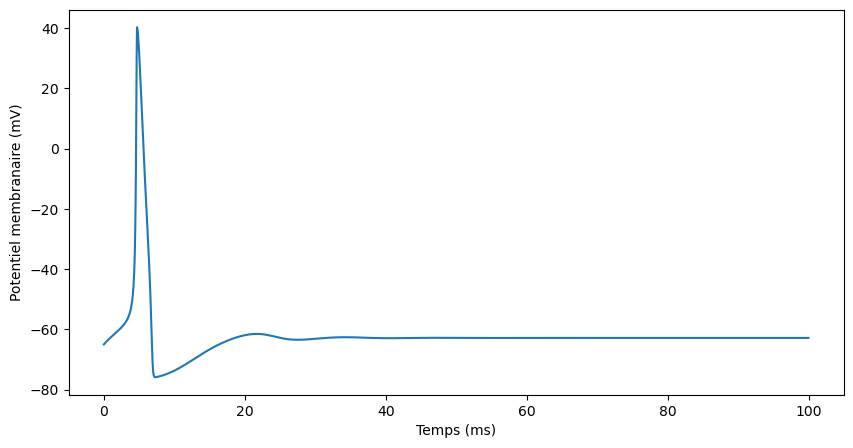

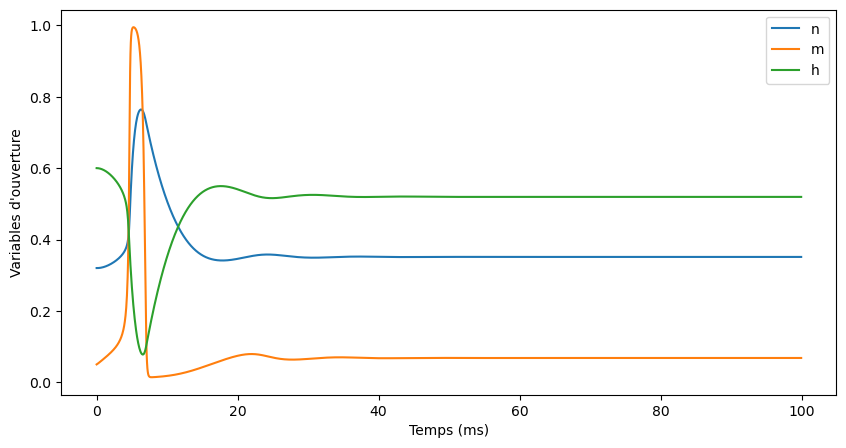

In [8]:
def plotNeuron(times, neuron):
    plt.figure(1, figsize=(10,5))
    plt.plot(times, neuron.l_Vm)
    plt.ylabel("Potentiel membranaire (mV)")
    plt.xlabel("Temps (ms)")

    plt.figure(2, figsize=(10,5))
    plt.plot(times, neuron.l_n, label="n")
    plt.plot(times, neuron.l_m, label="m")
    plt.plot(times, neuron.l_h, label="h")
    plt.xlabel("Temps (ms)")
    plt.ylabel("Variables d'ouverture")

    plt.legend()
    plt.show()

plotNeuron(times, Neurone)

**Question 4 :** En comparant l'évolution de ces variables avec les différentes phases du potentiel d'action, que remarquez vous ?

Lorsque le potentiel d'action augmente, la variable h diminue. A l'inverse, les variables m et n augmentent avec le potentiel d'action.

On veut étudier la réponse du neurone HH à différent courants de stimulation.
Pour 3 µA le neurone répond à la stimulation par un unique spike.

**Question 5 :** 
- Déterminer manuellement l'amplitude minimale de stimulation nécessaire pour générer des potentiels d'action répétés sur toute la durée de la simulation ("repetitive firing")
- Tracer la réponse du neurone (V) à cette stimulation.
    
! *N'oubliez pas de remettre ensuite le courant de stimulation à la valeur demandée initialement (3 µA) pour la suite du TD.*

In [9]:
# Determination de l'amplitude permettant le repetitive firing

def rep_firing(plage):
    for Is in plage:
        n = NeuroneHH()
        n, times = stimul(n, dt, Is, T)
        if len(n.l_spike_t) > 2:
            return Is, n
    return 0, None

Is_rep_firing, n_rep_firing = rep_firing(np.linspace(3.0, 10.0, 30))
print(Is_rep_firing, n_rep_firing)

6.137931034482759 <__main__.NeuroneHH object at 0x0000011528976900>


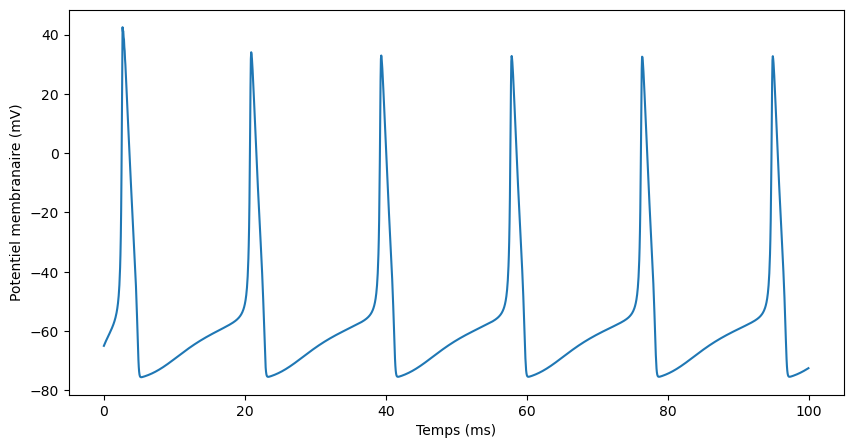

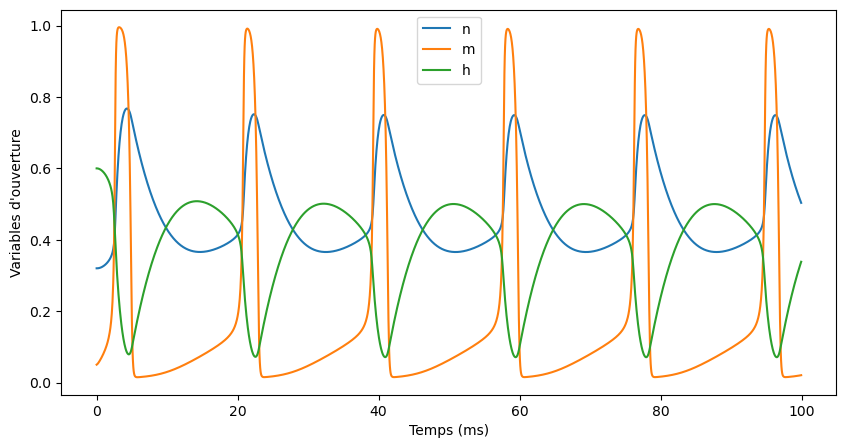

In [10]:
# Tracé du potentiel membranaire 

plotNeuron(times, n_rep_firing)

Donc on obtient un comportement de 'repetitive firing' pour Is qui vaut environ 6.137931034482759 µA.

**Question 6 :**
Augmenter la conductance du sodium, telle que $g_\mathrm{Na2} = 1.2g_\mathrm{Na}$. Stimuler à nouveau ce neurone selon le protocole de stimulation initial (3 µA pendant 100 ms) et tracer la réponse du neurone.

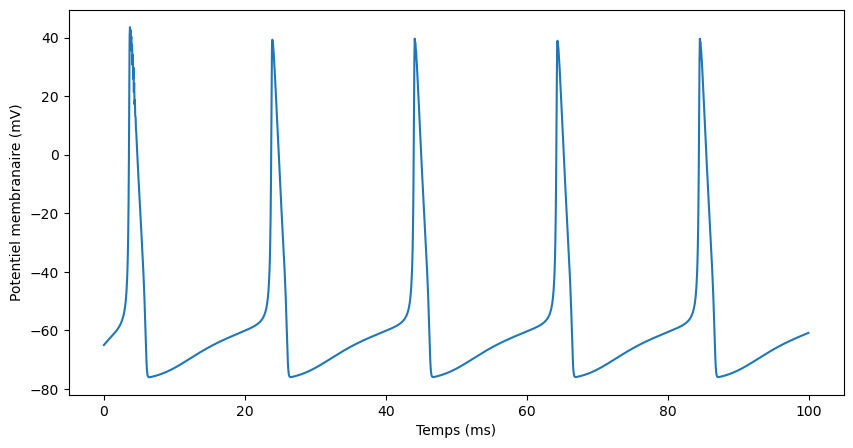

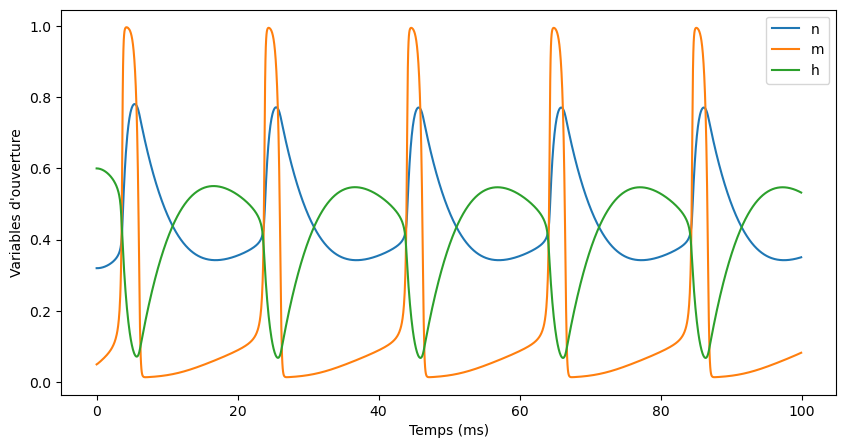

In [11]:
neurone1 = NeuroneHH()
neurone1.g_Na = 1.2*neurone1.g_Na

#paramétres de simulation
dt = 0.05  # pas de temps en ms
Is = 3.0  # courant de stimulation en uA
T = 100.0 # temps de simulation en ms

neurone1, times = stimul(neurone1, dt, Is, T)

plotNeuron(times, neurone1)

**Question 7 :** Que se passe-t-il ?

On constate du 'repetitive firing', même à une intensité de stimulation de 3.0 µA seulement.

**Question 8 :**
Dinmunuer la conductance du potasium, telle que $g_\mathrm{K2} = \frac{g_\mathrm{K}}{2}$. Stimuler à nouveau ce neurone selon le protocole de stimulation initial (3 µA pendant 100 ms) et tracer la réponse du neurone.

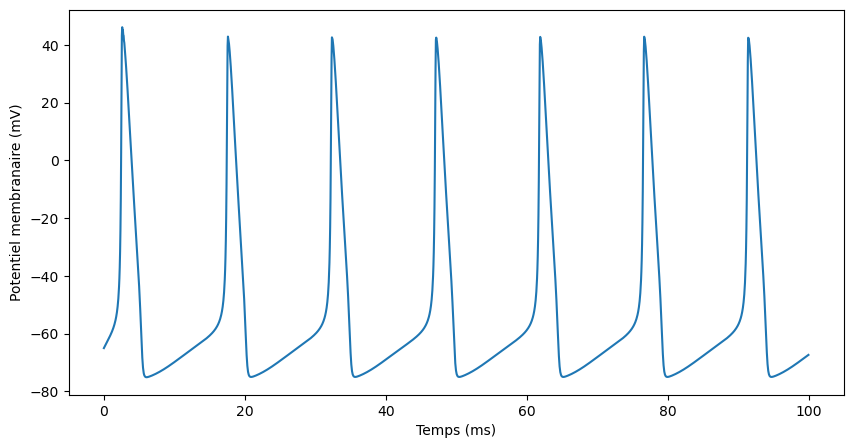

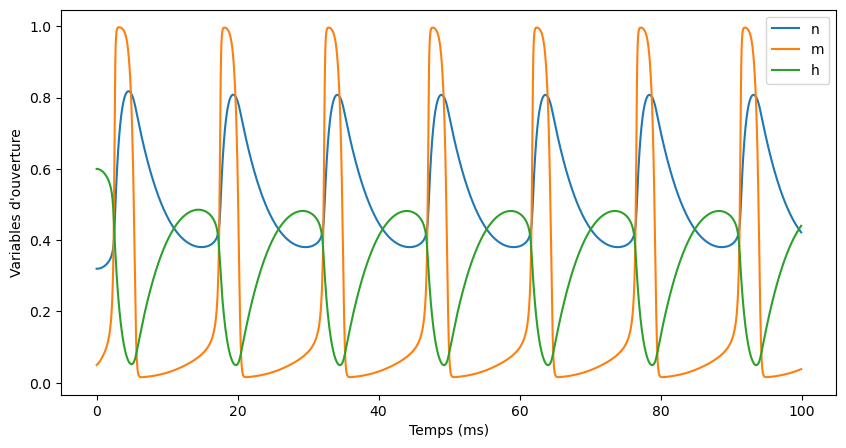

In [12]:
neurone2 = NeuroneHH()
neurone2.g_K = neurone2.g_K/2

#paramétres de simulation
dt = 0.05  # pas de temps en ms
Is = 3.0  # courant de stimulation en uA
T = 100.0 # temps de simulation en ms

# Boucle de simulation
neurone2, times = stimul(neurone2, dt, Is, T)

plotNeuron(times, neurone2)

**Question 9 :** Comparer le modèle de Hodgkin-Huxley avec le modèle LIF (étudié dans le cahier jupyter précédent).

Le modèle de Hodgkin-Huxley permet d'utiliser des équations qui fonctionnent pour toutes les phases du neurone, qu'il soit en train d'émettre un spike ou non. En fixant une valeur de conductance sodium forte, de conductance potassium faible, ou une intensité de stimulation forte, on obtient pour le neurone HH un comportement similaire à celui d'un neurone LIF avec période de réfraction.